In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchinfo
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, Rescale, NoneTransform, BaselineNN, HistEqualizationTransform
import torch
from torch import nn
import torchvision
import torcheval
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [ ]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [24]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

,path,Split,Bone,Patient,FolderName,Study,Label
20189,MURA-v1.1\train\XR_SHOULDER\patient00478\study...,train,XR_SHOULDER,patient00478,study1_positive,study1,positive
16571,MURA-v1.1\train\XR_HAND\patient10883\study1_ne...,train,XR_HAND,patient10883,study1_negative,study1,negative
21037,MURA-v1.1\train\XR_SHOULDER\patient00744\study...,train,XR_SHOULDER,patient00744,study1_positive,study1,positive
27800,MURA-v1.1\train\XR_WRIST\patient02462\study1_n...,train,XR_WRIST,patient02462,study1_negative,study1,negative
14808,MURA-v1.1\train\XR_HAND\patient10244\study1_ne...,train,XR_HAND,patient10244,study1_negative,study1,negative
26553,MURA-v1.1\train\XR_SHOULDER\patient02537\study...,train,XR_SHOULDER,patient02537,study1_negative,study1,negative
20384,MURA-v1.1\train\XR_SHOULDER\patient00539\study...,train,XR_SHOULDER,patient00539,study1_positive,study1,positive
3939,MURA-v1.1\train\XR_ELBOW\patient05994\study1_n...,train,XR_ELBOW,patient05994,study1_negative,study1,negative
31260,MURA-v1.1\train\XR_WRIST\patient07129\study1_p...,train,XR_WRIST,patient07129,study1_positive,study1,positive
12520,MURA-v1.1\train\XR_HAND\patient04096\study1_ne...,train,XR_HAND,patient04096,study1_negative,study1,negative


We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


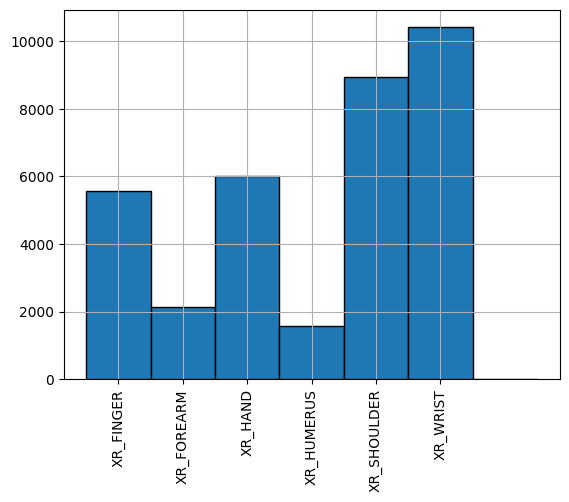

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

,path,Split,Bone,Patient,FolderName,Study,Label
0,MURA-v1.1\train\XR_ELBOW\patient00011\study1_n...,train,XR_ELBOW,patient00011,study1_negative,study1,negative
1,MURA-v1.1\train\XR_FINGER\patient04687\study1_...,train,XR_FINGER,patient04687,study1_negative,study1,negative
2,MURA-v1.1\train\XR_FOREARM\patient09634\study1...,train,XR_FOREARM,patient09634,study1_negative,study1,negative
3,MURA-v1.1\train\XR_HAND\patient10848\study1_ne...,train,XR_HAND,patient10848,study1_negative,study1,negative
4,MURA-v1.1\train\XR_HUMERUS\patient03089\study1...,train,XR_HUMERUS,patient03089,study1_negative,study1,negative
5,MURA-v1.1\valid\XR_SHOULDER\patient11765\study...,valid,XR_SHOULDER,patient11765,study1_negative,study1,negative
6,MURA-v1.1\train\XR_WRIST\patient05045\study1_n...,train,XR_WRIST,patient05045,study1_negative,study1,negative
7,MURA-v1.1\valid\XR_ELBOW\patient11809\study1_p...,valid,XR_ELBOW,patient11809,study1_positive,study1,positive
8,MURA-v1.1\valid\XR_FINGER\patient11480\study1_...,valid,XR_FINGER,patient11480,study1_positive,study1,positive
9,MURA-v1.1\train\XR_FOREARM\patient07091\study1...,train,XR_FOREARM,patient07091,study1_positive,study1,positive


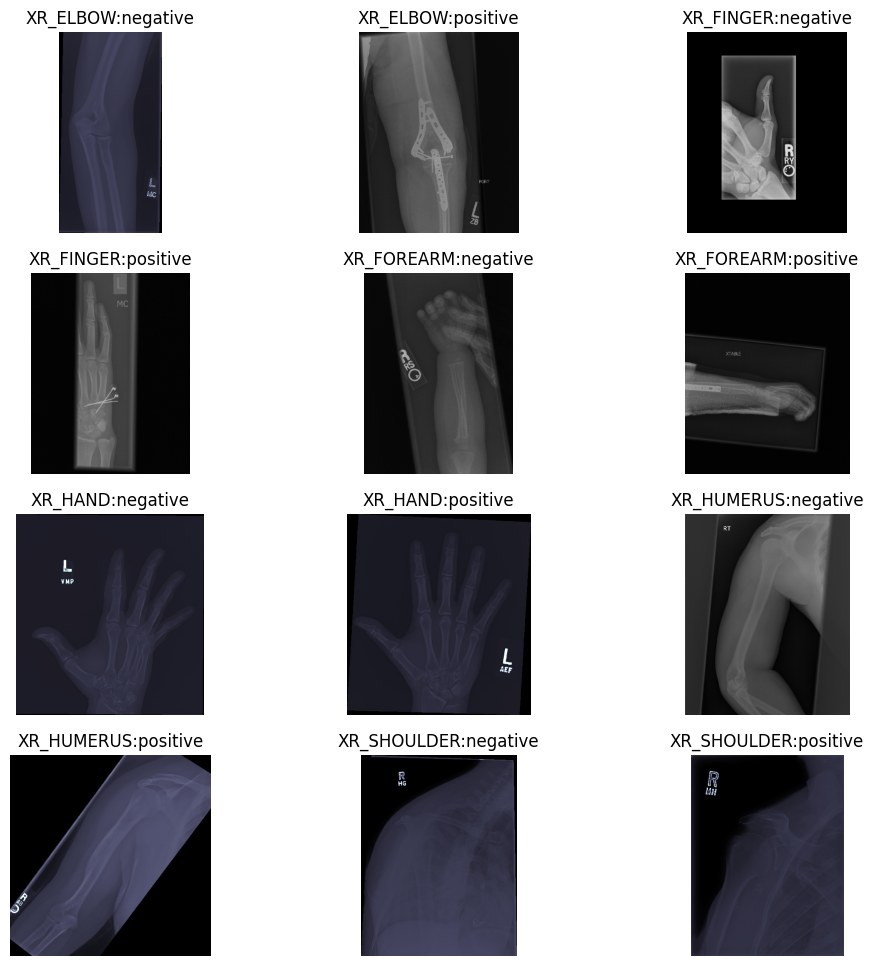

In [9]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [25]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

,path,Split,Bone,Patient,FolderName,Study,Label
17780,MURA-v1.1\train\XR_HUMERUS\patient02807\study1...,train,XR_HUMERUS,patient02807,study1_positive,study1,positive
18495,MURA-v1.1\train\XR_HUMERUS\patient03136\study1...,train,XR_HUMERUS,patient03136,study1_negative,study1,negative
18500,MURA-v1.1\train\XR_HUMERUS\patient03138\study1...,train,XR_HUMERUS,patient03138,study1_negative,study1,negative
38621,MURA-v1.1\valid\XR_HUMERUS\patient11631\study1...,valid,XR_HUMERUS,patient11631,study1_positive,study1,positive
17860,MURA-v1.1\train\XR_HUMERUS\patient02844\study1...,train,XR_HUMERUS,patient02844,study1_positive,study1,positive
17597,MURA-v1.1\train\XR_HUMERUS\patient02726\study1...,train,XR_HUMERUS,patient02726,study1_positive,study1,positive
17512,MURA-v1.1\train\XR_HUMERUS\patient02419\study1...,train,XR_HUMERUS,patient02419,study1_positive,study1,positive
38687,MURA-v1.1\valid\XR_HUMERUS\patient11660\study1...,valid,XR_HUMERUS,patient11660,study1_negative,study1,negative
17881,MURA-v1.1\train\XR_HUMERUS\patient02852\study1...,train,XR_HUMERUS,patient02852,study1_positive,study1,positive
18094,MURA-v1.1\train\XR_HUMERUS\patient02947\study1...,train,XR_HUMERUS,patient02947,study1_negative,study1,negative


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


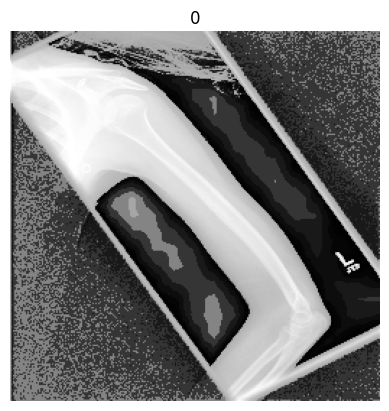

In [26]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    HistEqualizationTransform(),
    
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(2)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [27]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    #HistEqualizationTransform(),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022969925F90>, <torch.utils.data.dataloader.DataLoader object at 0x000002296BE447C0>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [52]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5, pretrained=False):

    #put in training mode
    model.train()
    #reset model parameters
    if not pretrained:
        model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        loss_per_epoch=0


        print(f"Epoch {epoch+1}/{num_epochs}")

        #batch computations
        for i, (inputs, labels) in enumerate(dataloader):
            print("batch number",i)
            if pretrained:
                pass
            else:
                inputs=inputs.view(inputs.shape[0],-1)
            #print(inputs.shape,inputs.dtype)
            if pretrained:
                outputs=model(inputs).squeeze()
            else:
                outputs=model(inputs)
            print("predictions after sigmoid: ",outputs[:10])
            labels=labels.type_as(outputs)
            print("real labels: ",labels[:10])
            #loss returns mean loss per batch unless specified otherwise
            batch_loss=loss_fn(outputs,labels)

            #add the batch_loss to epoch loss
            loss_per_epoch+=batch_loss.item()

            optimizer.zero_grad()
            #update parameters
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            #print(i, loss.item())
            # if i%8==0:
            #     print(f"Loss at iteration {i} is {round((loss_per_epoch/8),4)}")
            #     #loss_istory has acumulated the mean loss of 8 batches so we divide by 4 to get 
            #     # avg loss per batch
            #     loss_history.append(round((loss_per_epoch/8),4))
            #     loss_per_epoch=0
            if i % 9 == 0:
                print(f"Cumuative Loss at batch {i} is {round((loss_per_epoch/9),4)}")


        print(f"Loss at epoch {epoch+1} is {round((loss_per_epoch/len(dataloader)),4)}")
        loss_history.append(round((loss_per_epoch/len(dataloader)),4))
    return loss_history
    
@torch.no_grad()    
def evaluate(model, dataloader, loss_fn, accuracy_fn, pretrained=False):
    model.eval()

    loss_history=[]
    eval_loss=0
    eval_acc=0
    
    for i, (inputs, labels) in enumerate(dataloader):
        if pretrained:
            pass
        else:
            inputs=inputs.view(inputs.shape[0],-1)
        if pretrained:
            outputs=model(inputs).squeeze()
        else:
            outputs=model(inputs)
        labels=labels.type_as(outputs)
        loss=loss_fn(outputs,labels)
        eval_loss+=loss.item()
        accuracy_fn.update(outputs,labels)
        print("accuracy is: ",accuracy_fn.compute())
        #Binary accuracy returns the accuracy per batch
        # eg if batch size is 32 and 25 are correct, it returns tensor(25/32)
        eval_acc+=accuracy_fn.compute()

        loss_history.append(round(loss.item(),4))
    eval_loss=eval_loss/len(dataloader)
    eval_acc=eval_acc/len(dataloader)
    print(f"\n Test loss: {eval_loss:.5f}, Test acc: {eval_acc*100:.2f}%\n")
    return loss_history

In [46]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
#BCELoss(sigmoid_output,true_labels)
loss_fn=torch.nn.BCELoss(reduction='mean')
model=BaselineNN(input_size=input_size, hidden_size=128, output_size=1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
accuracy_fn=torcheval.metrics.BinaryAccuracy(threshold=0.5)
print(type(accuracy_fn))
train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=2)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn=accuracy_fn)




Input size: 196608
<class 'torcheval.metrics.classification.accuracy.BinaryAccuracy'>
accuracy is:  tensor(0.5312)
accuracy is:  tensor(0.5000)
accuracy is:  tensor(0.4792)
accuracy is:  tensor(0.4844)
accuracy is:  tensor(0.5063)
accuracy is:  tensor(0.5365)
accuracy is:  tensor(0.5402)
accuracy is:  tensor(0.5586)
accuracy is:  tensor(0.5660)

 Test loss: 0.69011, Test acc: 52.25%



In [ ]:
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')

In [40]:
transormation_dict= {

    'train':torchvision.transforms.Compose([]),
    
    
    'train_resnet': torchvision.transforms.Compose(
        [torchvision.transforms.Resize([256,256]),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        
    ]
    )


}

In [54]:
#freeze all layers
#use weights and default so as not to get warnings
#use pretrained weights
weights=torchvision.models.ResNet18_Weights.DEFAULT
resnet18 = torchvision.models.resnet18(weights=weights)
for param in resnet18.parameters():
    param.requires_grad=False

weights.transforms()
in_features=resnet18.fc.in_features
#output only 1 value for binary classification
#the output is not passed through sigmoid
resnet18.fc=torch.nn.Linear(in_features,1)
#torchinfo.summary(resnet18, input_size=(32, 3, 256, 256),col_names=["input_size", "output_size", "num_params", "trainable"], verbose=2)
#only optimize the parameters of the last layer
optimizer=torch.optim.Adam(resnet18.fc.parameters(),lr=0.001)
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCEWithLogitsLoss(reduction='mean')
accuracy_fn=torcheval.metrics.BinaryAccuracy(threshold=0.5)
model=resnet18
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=1, pretrained=True)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)



Input size: 196608
Epoch 1/1
batch number 0
predictions after sigmoid:  tensor([-0.7633, -0.8191, -0.5923, -0.5917, -1.4640, -0.5505, -0.8732, -1.2073,
        -0.9801, -1.2398], grad_fn=<SliceBackward0>)
real labels:  tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0.])
Cumuative Loss at batch 0 is 0.0825
batch number 1
predictions after sigmoid:  tensor([-0.3732, -0.0966,  0.0118, -0.7830,  0.0281, -0.6642, -0.0569, -0.5476,
        -0.2118, -0.3334], grad_fn=<SliceBackward0>)
real labels:  tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 0.])
batch number 2
predictions after sigmoid:  tensor([ 0.3584, -0.4537,  0.1738,  0.6114,  0.0820, -0.1563,  0.1257,  0.4772,
         0.3830, -0.0864], grad_fn=<SliceBackward0>)
real labels:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
batch number 3
predictions after sigmoid:  tensor([-0.0092, -0.1391,  0.0862, -0.1213,  0.1988,  0.0315,  0.0082,  0.2589,
        -0.3200, -0.1971], grad_fn=<SliceBackward0>)
real labels:  tensor([0., 0., 1., 0., 0., 

In [53]:
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


accuracy is:  tensor(0.4062)
accuracy is:  tensor(0.3906)
accuracy is:  tensor(0.4479)
accuracy is:  tensor(0.4609)
accuracy is:  tensor(0.4875)
accuracy is:  tensor(0.5052)
accuracy is:  tensor(0.5134)
accuracy is:  tensor(0.5234)
accuracy is:  tensor(0.5139)

 Test loss: 0.66242, Test acc: 47.21%

